<br />

<div style="text-align: center;">
<font size="7">Image Search</font>
</div>

<br />

In [1]:
import os
import numpy as np
import scipy.io
import json
import pickle
import chainer
from chainer import Variable, Chain
from chainer import links as L, functions as F
from chainer import optimizers, serializers

import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

from VariableLengthUtils.RNN import BLSTM, LSTM
from VariableLengthUtils.EmbedID import EmbedID
from VariableLengthUtils.functions import batchsort

# Prepare dataset

## Raw dataset
- Download datasets from here: http://cs.stanford.edu/people/karpathy/deepimagesent/
- Extract the downloaded file to ../data/

In [2]:
datafile = 'data/flickr8k/dataset.json'

with open(datafile, 'r') as f:
    datas = json.load(f)['images']

## Preprocess
- convert token into ID
- length of idset array is 8000 * 5 = 40000
- captions of a image data with $imgid$ are $idset\left[imgid * 5:imgid * 5 + 5\right]$

In [3]:
idset = []
wd2id = {'<bos>': 0,
         '<eos>': 1,
         '<unk>': 2,}
count = {}

max_wd_count = 5 # if #occurrences of a token is less than it,
                 #              convert the token into <unk>.

for data in datas:
    for sentence in data['sentences']:
        for wd in sentence['tokens']:
            if wd not in count:
                count[wd] = 0
            count[wd] += 1

for data in datas:
    for sentence in data['sentences']:
        sid = []
        for wd in sentence['tokens']:
            if count[wd] < max_wd_count:
                sid.append(wd2id['<unk>'])
            else:
                if wd not in wd2id:
                    wd2id[wd] = len(wd2id)
                sid.append(wd2id[wd])
        idset.append(sid)

idset = [np.asarray(x_, dtype=np.int32) for x_ in idset]

In [4]:
# save converted dataset
idfile = 'data/flickr8k/idset.pkl'
wd2idfile = 'data/flickr8k/wd2id.pkl'
with open(idfile, 'wb') as f:
    pickle.dump(idset, f)

with open(wd2idfile, 'wb') as f:
    pickle.dump(wd2id, f)

## Load dataset
- Load preprocessed data

In [2]:
idfile = 'data/flickr8k/idset.pkl'
wd2idfile = 'data/flickr8k/wd2id.pkl'
featfile = 'data/flickr8k/vgg_feats.mat'

with open(idfile, 'rb') as f:
    idset = pickle.load(f)

with open(wd2idfile, 'rb') as f:
    wd2id = pickle.load(f)

feats_ = scipy.io.loadmat(featfile)['feats'].T
feats = feats_.repeat(5, axis=0)

# Model
- Embed sentence into the same feature space as image.

## Simple LSTM model

In [3]:
class LSTMEmbed(Chain):
    def __init__(self, in_size, out_size, train=True):
        super().__init__(
            embed=L.EmbedID(in_size, 512),
            lstm=L.LSTM(512, 512),
            out=L.Linear(512, out_size)
        )
        self.train = train
    
    def __call__(self, x):
        x = F.transpose_sequence(x)
        for x_ in x:
            self.lstm(F.dropout(self.embed(x_), train=self.train))
        h = self.out(F.dropout(self.lstm.h, train=self.train))
        return h
    
    def reset_state(self):
        self.lstm.reset_state()

In [4]:
imgembed = LSTMEmbed(len(wd2id), feats.shape[1])
x = batchsort(idset)[:20]
y = imgembed(x)
y.shape

(20, 4096)

## BiLSTM model

In [5]:
class ImgEmbed(Chain):
    def __init__(self, in_size, out_size, train=True):
        super().__init__(
            embed = EmbedID(in_size, 512),
            blstm = BLSTM(512, 512),
            lstm  = LSTM(512, 1024),
            out   = L.Linear(1024, out_size)
        )
        self.train = train
    
    def __call__(self, x):
        h = self.embed(x, dropout=self.train)
        h = self.blstm(h)
        h= self.lstm(h)
        h = self.out(F.dropout(h, train=self.train))
        return h
    
    def reset_state(self):
        self.blstm.reset_state()
        self.lstm.reset_state()

In [6]:
imgembed = ImgEmbed(len(wd2id), feats.shape[1])
x = batchsort(idset)[:20]
y = imgembed(x)
y.shape

(20, 4096)

# Training

## Setup model

In [7]:
n_data = len(idset)
n_vocab = len(wd2id)

n_epochs = 200
batchsize = 100

save_cycle = 20
save_dir = './model/lstmembed_4096'
model_name = 'model_{}epoch.npz'
optim_name = 'optim_{}epoch.npz'

In [8]:
model = LSTMEmbed(n_vocab, feats.shape[1])

optimizer = optimizers.Adam()
optimizer.setup(model)

## Train

In [9]:
pb = FloatProgress(min=0, max=(n_data//batchsize)*n_epochs)
display(pb)

errors = []
for epoch in range(1, n_epochs + 1):
    shuffle_idx = np.random.permutation(np.arange(n_data))
    for i in range(0, n_data, batchsize):
        batch_idx = shuffle_idx[i:i+batchsize if i+batchsize < n_data else n_data]
        x_batch = [idset[idx] for idx in batch_idx]
        y_batch = feats[batch_idx]
        x_batch, y_batch = batchsort(x_batch, y_batch)
        
        model.reset_state()
        loss = F.mean_squared_error(model(x_batch), y_batch)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        errors.append(loss.data)
        pb.value += 1
        
    print("epoch {}: loss = {}".format(epoch, loss.data))
    
    if epoch % save_cycle == 0:
        model_fp = os.path.join(save_dir, model_name.format(epoch))
        optim_fp = os.path.join(save_dir, optim_name.format(epoch))
        serializers.save_npz(model_fp, model)
        serializers.save_npz(optim_fp, optimizer)
        print('save model and optimizer: {}, {}'.format(model_fp, optim_fp))

epoch 1: loss = 1.05745267868042
epoch 2: loss = 1.0224376916885376
epoch 3: loss = 1.0450522899627686
epoch 4: loss = 1.0502630472183228
epoch 5: loss = 0.9869892597198486
epoch 6: loss = 0.9716061949729919
epoch 7: loss = 0.9330874085426331
epoch 8: loss = 0.9541282057762146
epoch 9: loss = 0.9190133810043335
epoch 10: loss = 0.9376640319824219
epoch 11: loss = 0.9843006134033203
epoch 12: loss = 1.004133939743042
epoch 13: loss = 0.9328920841217041
epoch 14: loss = 0.9882013201713562
epoch 15: loss = 0.9031590223312378
epoch 16: loss = 0.9104897975921631
epoch 17: loss = 0.9436786770820618
epoch 18: loss = 0.8794094324111938
epoch 19: loss = 0.9833486676216125
epoch 20: loss = 0.9442304968833923
save model and optimizer: ./model/lstmembed_4096model_20epoch.npz, ./model/lstmembed_4096optim_20epoch.npz
epoch 21: loss = 0.9449388384819031
epoch 22: loss = 0.9603814482688904
epoch 23: loss = 0.8824542760848999
epoch 24: loss = 0.9276063442230225
epoch 25: loss = 0.8549638390541077
epoch

KeyboardInterrupt: 

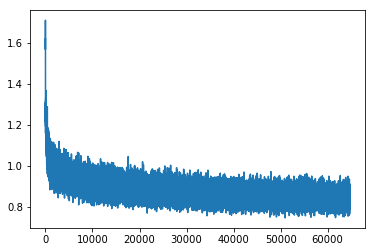

In [10]:
plt.plot(errors)

# Older-Embeddings of images and language

In [29]:
class AbsLSTMEmbed(Chain):
    def __init__(self, in_size, out_size, train=True):
        super().__init__(
            embed=L.EmbedID(in_size, 300),
            lstm=L.LSTM(300, 300),
            out=L.Linear(300, out_size)
        )
        self.train = train
    
    def __call__(self, x):
        x = F.transpose_sequence(x)
        for x_ in x:
            self.lstm(F.dropout(self.embed(x_), train=self.train))
        h = self.out(F.dropout(self.lstm.h, train=self.train))
        return F.absolute(h)
    
    def reset_state(self):
        self.lstm.reset_state()

In [31]:
class CNNOut(Chain):
    def __init__(self, in_size, out_size):
        super().__init__(
            linear=L.Linear(in_size, out_size)
        )
    
    def __call__(self, x):
        return F.absolute(self.linear(x))

In [ ]:
def score(x, y):
    return -F.batch_l2_norm_squared(F.relu(y - x))

def lossfun(c, )

# Dimension reduction using DAE
- Reduce #dimensions of feature space using Denoising Autoencoder(DAE).

## DAE

In [27]:
class DAE(Chain):
    def __init__(self, in_size, mid_size):
        super().__init__(
            encoder=L.Linear(in_size, mid_size),
            decoder=L.Linear(mid_size, in_size)
        )
    
    def __call__(self, x):
        # add gaussian noise
        eps = np.random.randn(x.size).reshape(x.shape)
        x += eps
        
        h = F.sigmoid(self.encoder(x))
        h = self.decoder(h)
        return h

In [28]:
dae = DAE(feats.shape[1], 512)
y = dae(feats[:2])
y.shape

(2, 4096)

## Train DAE

### Setup

In [29]:
n_feats, in_size = feats_.shape
mid_size = 512

n_epochs = 200
batchsize = 100

save_cycle = 10
save_dir = './model/dae_512/'
model_name = 'dae_{}epoch.npz'
optim_name = 'dae_{}epoch.npz'

In [30]:
dae = DAE(in_size, mid_size)
optimizer = optimizers.Adam()
optimizer.setup(dae)

### Train

In [32]:
fp = FloatProgress(min=0, max=(n_feats//batchsize)*n_epochs)
display(fp)

errors = []
for epoch in range(1, n_epochs + 1):
    shuffle_idx = np.random.permutation(np.arange(n_feats))
    for i in range(0, n_feats, batchsize):
        batch_idx = shuffle_idx[i:i+batchsize if i+batchsize < n_feats else n_feats]
        x_batch = feats[batch_idx]

        loss = F.mean_squared_error(dae(x_batch), x_batch)
        
        dae.cleargrads()
        loss.backward()
        optimizer.update()
        
        errors.append(loss.data)
        fp.value += 1
    
    print("epoch {}: loss = {}".format(epoch, loss.data))
    
    if epoch % save_cycle == 0:
        model_fp = save_dir + model_name.format(epoch)
        optim_fp = save_dir + optim_name.format(epoch)
        serializers.save_npz(model_fp, model)
        serializers.save_npz(optim_fp, optimizer)
        print('save model and optimizer: {}, {}'.format(model_fp, optim_fp))

epoch 1: loss = 1.8921667337417603
epoch 2: loss = 1.6493866443634033
epoch 3: loss = 1.6100345849990845
epoch 4: loss = 1.5268738269805908
epoch 5: loss = 1.461970329284668
epoch 6: loss = 1.451326847076416
epoch 7: loss = 1.4093059301376343
epoch 8: loss = 1.3982040882110596
epoch 9: loss = 1.386332392692566
epoch 10: loss = 1.349475383758545
save model and optimizer: ./model/dae_512/dae_10epoch.npz, ./model/dae_512/dae_10epoch.npz
epoch 11: loss = 1.3274803161621094
epoch 12: loss = 1.350356101989746
epoch 13: loss = 1.32452392578125
epoch 14: loss = 1.2792998552322388
epoch 15: loss = 1.3295130729675293
epoch 16: loss = 1.306878924369812
epoch 17: loss = 1.2838226556777954
epoch 18: loss = 1.291928768157959
epoch 19: loss = 1.2678831815719604
epoch 20: loss = 1.251905083656311
save model and optimizer: ./model/dae_512/dae_20epoch.npz, ./model/dae_512/dae_20epoch.npz
epoch 21: loss = 1.2486430406570435
epoch 22: loss = 1.2438158988952637
epoch 23: loss = 1.2417033910751343
epoch 24:

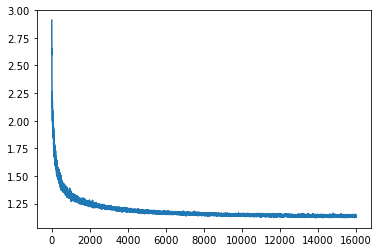

In [33]:
plt.plot(errors)

### Evatuate